<a href="https://colab.research.google.com/github/vbanai/Linear_and_Logistic_Regression_Projects/blob/main/Tabular_playground_2021_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset is downloaded from Kaggle, which was created for a Tabular Playground competition to test the ML regression skills. The dataset is quite approachable to achieve relatively good results in the begining, but it is tough to improve the predictions. I tested several advanced technics and approaches to make some improvement compared to the standard methods.

In [1]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [ ]:
!pip install feature-engine --user
from feature_engine.outliers import Winsorizer

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir - p ~/.kaggle 
! cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c tabular-playground-series-jan-2021

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "viktorbanai" # username from the json file
os.environ['KAGGLE_KEY'] = "9431db56af1a1a63cab88b4e516a2248" # key from the json file
!kaggle competitions download -c tabular-playground-series-jan-2021 # api copied from kaggle


  0% 0.00/469k [00:00<?, ?B/s]
100% 469k/469k [00:00<00:00, 68.9MB/s]
 71% 17.0M/23.9M [00:00<00:00, 44.6MB/s]
100% 23.9M/23.9M [00:00<00:00, 79.6MB/s]
 65% 25.0M/38.4M [00:00<00:00, 29.1MB/s]
100% 38.4M/38.4M [00:00<00:00, 78.1MB/s]


In [ ]:
!unzip "/content/sample_submission.csv.zip" -d "/content/p/"

In [3]:
!unzip "/content/test.csv.zip" -d "/content/p/"
!unzip "/content/train.csv.zip" -d "/content/p/"

Archive:  /content/test.csv.zip
  inflating: /content/p/test.csv     
Archive:  /content/train.csv.zip
  inflating: /content/p/train.csv    


Preparinging train and test dataset for the training and testing

In [ ]:
dataframe_raw = pd.read_csv("/content/p/sample_submission.csv")


In [39]:
dataframe_test = pd.read_csv("/content/p/test.csv")
dataframe_original = pd.read_csv("/content/p/train.csv")





In [40]:
#create dependent and independent variables

dataframe_train_raw=dataframe_original.drop(['id'], axis=1)
dataframe_target=dataframe_train_raw.pop('target')

In [ ]:
#datatypes of the columns

dataframe_train_raw.info()

In [ ]:
#missing values
print(dataframe_train_raw.isnull().sum()) 
print(dataframe_target.isnull().sum())

Describing the dataset

In [16]:
dataframe_original_ = pd.read_csv("/content/p/train.csv")
dataframe_original_.describe().T

,count,mean,std,min,25%,50%,75%,max
id,300000.0,249825.145857,144476.732562,1.000000,124656.500000,249738.500000,374836.250000,499999.000000
cont1,300000.0,0.506873,0.203976,-0.082263,0.343078,0.484005,0.643789,1.016227
cont2,300000.0,0.497898,0.228159,-0.031397,0.319170,0.553209,0.731263,0.859697
cont3,300000.0,0.521557,0.200770,0.020967,0.344096,0.551471,0.648315,1.006955
cont4,300000.0,0.515683,0.233035,0.152761,0.294935,0.482880,0.748705,1.010402
cont5,300000.0,0.502022,0.220701,0.276377,0.284108,0.451733,0.670660,1.034261
cont6,300000.0,0.526515,0.217909,0.066166,0.356163,0.470988,0.694043,1.043858
cont7,300000.0,0.487890,0.181096,-0.097666,0.346600,0.466825,0.581292,1.066167
cont8,300000.0,0.525163,0.216221,0.217260,0.341486,0.483460,0.685250,1.024427
cont9,300000.0,0.459857,0.196685,-0.240604,0.330832,0.416843,0.575041,1.004114


*Count* is the sum of rows </br>
*Mean* value is balanced, there is no big differences in the different columns. So scale of the dataset for each columns are quite the same, no need to bring all the datapoints to the same scale, as it seems to be a standardized dataset relates to the independent variables.
</br>
*Quantiles* are lines which devide the data into equally sized groups.
25% quantile means that value you can get at the last place of first 1/4 dataset, if you sort the data into ascending order. 50% quantile is the median. 
For example the max value of cont1 column at the 75%  is 0.643789
</br>

**Distribution** of the variables</br>
</br>
The best scenario for LR is if all of your variables have normal distribution.
In this dataset regarding independent variables most of the time you can find negative and positive skewed distribution. Checking the density plots, the QQ plots and the boxplots, it seems that "cont7" variable and the "target" dependent variable approximate the normal distribution with having outlier values.





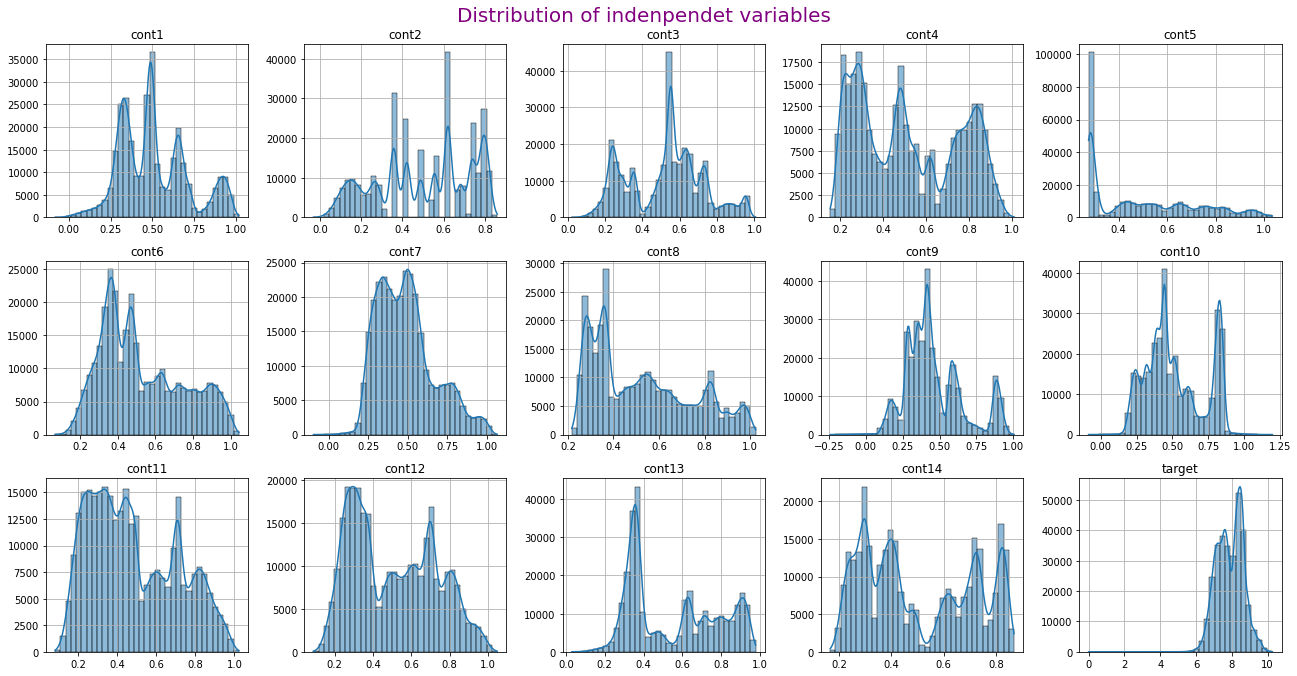

In [53]:
#Distribution of  variables
dataframe_original_ = pd.read_csv("/content/p/train.csv")
plt.rcParams.update({'figure.figsize': (18,15)})
plt.suptitle('Distribution of indenpendet variables', y=1.01, fontsize=20, color='purple')
t=["cont1", 	"cont2", 	"cont3", 	"cont4", 	"cont5", 	"cont6", 	"cont7", 	"cont8", 	"cont9", 	"cont10", 	"cont11", 	"cont12", 	"cont13", "cont14", "target"]
for i in range(15):
    plt.subplot(5, 5, i+1)
    sns.histplot(dataframe_original_[t[i]], bins=35, kde=True)
    plt.ylabel(None)
    plt.xlabel(None)
    plt.title(t[i])
    plt.grid()
    
plt.tight_layout()

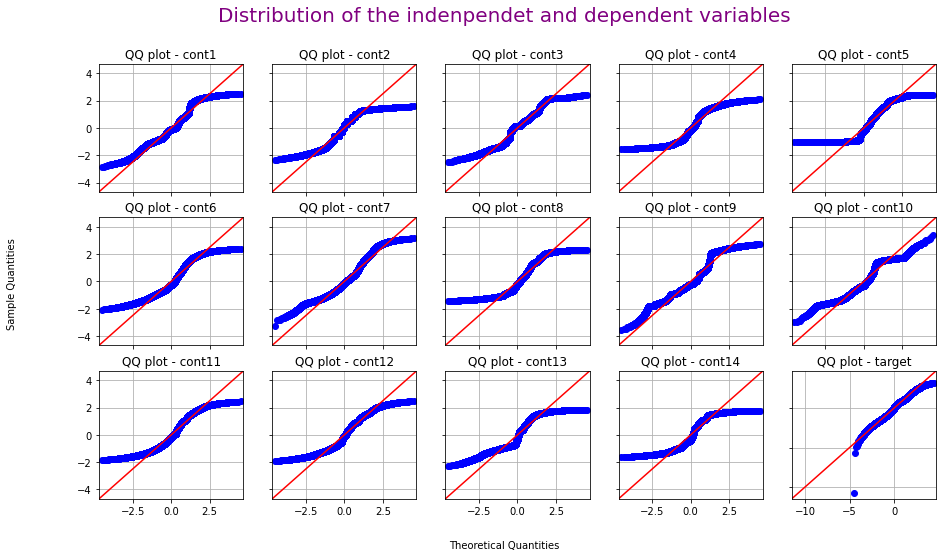

<Figure size 1296x1080 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt


fig1, ax1=plt.subplots(3,5, figsize=(15,8))
fig1.text(0.5, 0.04, 'Theoretical Quantities', ha='center')
fig1.text(0.04, 0.5, 'Sample Quantities', va='center', rotation='vertical')

contnr=1
cols=5
rows=3

for i in range(rows):
  for j in range(cols):
    if contnr==15:
      sm.qqplot(dataframe_original_["target"], ax=ax1[i,j], line='45', fit="True")   
      ax1[i, j].set_title('QQ plot - target')
      ax1[i, j].set_xlabel
      ax1[i, j].grid()
      continue
      
    sm.qqplot(dataframe_original_["cont"+str(contnr)], ax=ax1[i,j], line='45', fit="True")   
    ax1[i, j].set_title('QQ plot - cont'+str(contnr))
    ax1[i, j].set_xlabel
    ax1[i, j].grid()
    contnr+=1



for ax in ax1.flat:
    ax.set(xlabel='', ylabel='')
    
for ax in ax1.flat:  # delet the unnecessary x and y labeling
    ax.label_outer()

fig1.suptitle('Distribution of the indenpendet and dependent variables', fontsize=20, color='purple')


plt.show()

plt.tight_layout()

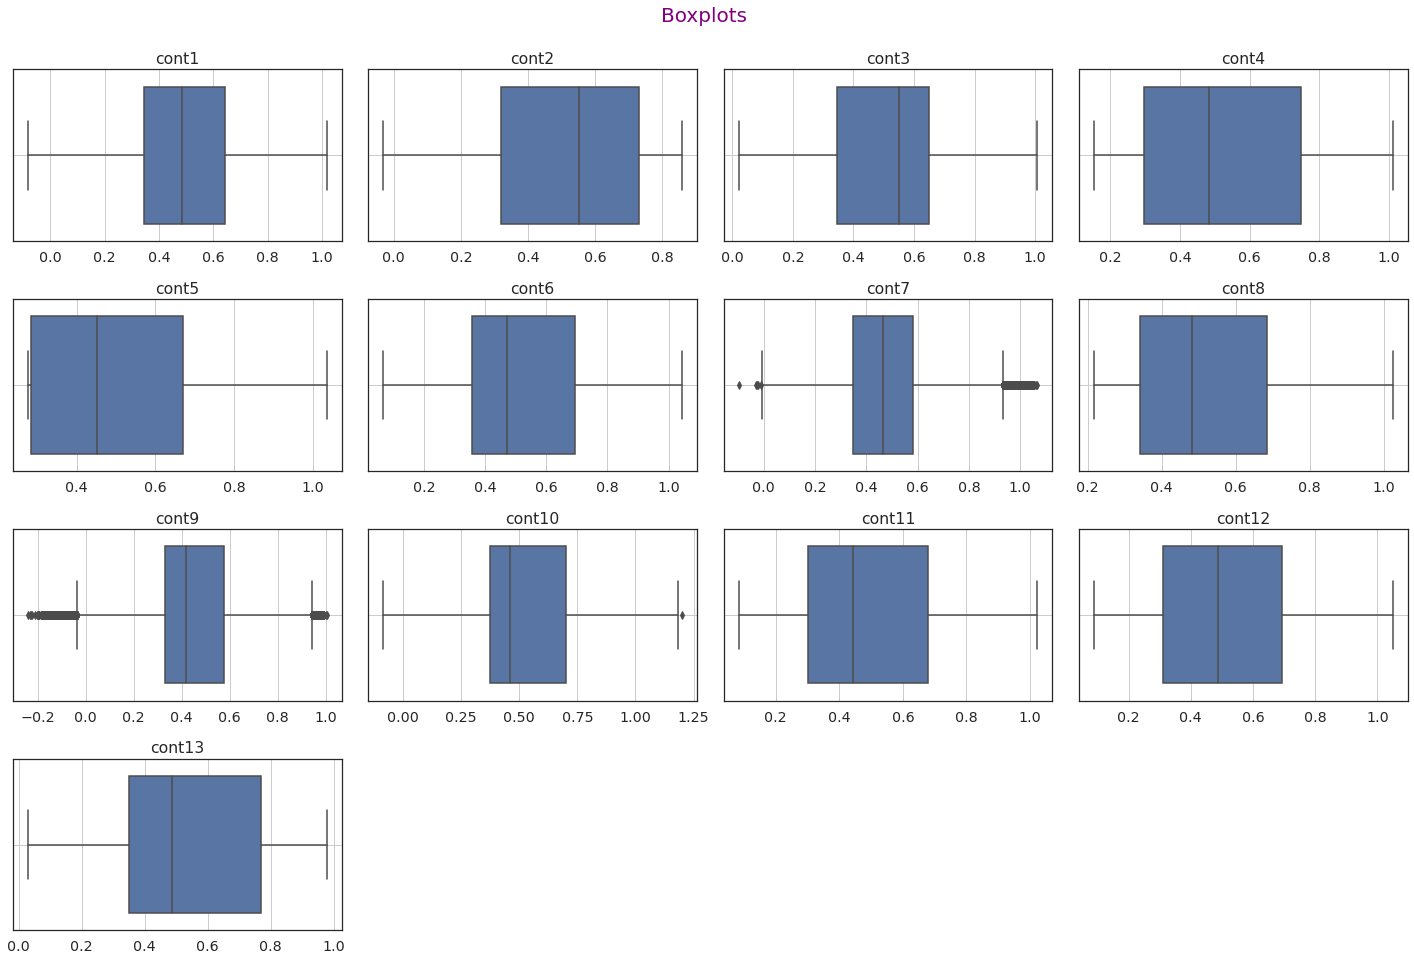

In [59]:
sns.set(style='white',font_scale=1.3, rc={'figure.figsize':(20,13)})



plt.figure(figsize=(20, 13))
plt.suptitle('Boxplots', y=1.03, fontsize=20, color='purple')

t=[column for column in dataframe_train_raw]
for i in range(13):
    plt.subplot(4, 4, i+1)
    sns.boxplot(x=dataframe_train_raw[t[i]])
    plt.ylabel(None)
    plt.xlabel(None)
    plt.title(t[i])
    plt.grid()
    
plt.tight_layout()

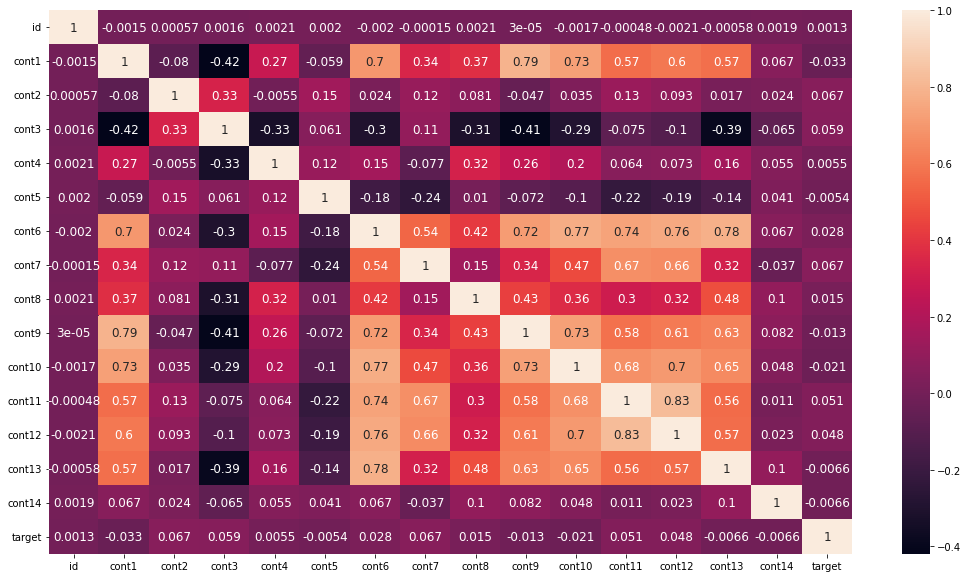

In [54]:
# checking the correlation among the variables

corrmat=dataframe_original.corr()
plt.subplots(figsize=(18,10))
sns.heatmap(corrmat, annot=True, annot_kws={'size':12})
plt.show()

1.) PREDICTING WITH STATSMODELS

In [41]:
X_train, X_test, y_train, y_test=train_test_split(dataframe_train_raw, dataframe_target, test_size=0.2, random_state=0)

In [42]:
x=sm.add_constant(dataframe_train_raw)  #adding constant

In [43]:
results=sm.OLS(dataframe_target,x).fit()   #ordinary least squared
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     407.5
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        08:37:40   Log-Likelihood:            -3.2970e+05
No. Observations:              300000   AIC:                         6.594e+05
Df Residuals:                  299985   BIC:                         6.596e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7171      0.009    839.675      0.000       7.699       7.735
cont1         -0.2680      0.012    -22.331      0.000      -0.292      -0.244
cont2          0.1352      0.006     20.840      0.000       0.122       0.148
cont3          0.0726      0.009      8.284      0.000       0.055       0.090
cont4          0.1077      0.006     16.748      0.000       0.095       0.120
cont5          0.0206      0.006      3.195      0.001       0.008       0.033
cont6          0.3385      0.014     24.119      0.000       0.311       0.366
cont7          0.1546      0.011     14.250      0.000       0.133       0.176
cont8          0.0532      0.007      7.137      0.000       0.039       0.068
cont9          0.0500      0.013      3.984      0.000       0.025       0.075
cont10        -0.3897      0.012    -32.251      0.000      -0.413      -0.366
cont11         0.1213      0.012     10.119      0.000       0.098       0.145
cont12         0.1521      0.012     12.371      0.000       0.128       0.176
cont13        -0.1420      0.010    -13.994      0.000      -0.162      -0.122
cont14        -0.0110      0.006     -1.704      0.088      -0.024       0.002
==============================================================================
Omnibus:                     6305.224   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3707.808
Skew:                          -0.110   Prob(JB):                         0.00
Kurtosis:                       2.501   Cond. No.                         26.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation of the OLS regression results</br>
</br>
In spite of the fact that the independent variables don't have normal distributon, the OLS results show that there are linear relationship between the feature and target values, and the model fits quite well.</br>
</br>
R-SQUARED and ADJUSTED R-SQUARED values: R_Squared value quantify the model performance, how good the model is at predicting. R-SQUARED and ADJUSTED R-SQUARED  values are the same now, which means that all variables are relevant in the model, and there is no feature which would deteriorate the model performance (if they differ from each other it means we have non useful predictors(features)). The R-squared value(0-1) can be considered to be low which normally means that independent variables don't predict dependent variable well. But even when R-squared is low, low P values still indicate a real relationship between the significant predictors and the response variable. So let's check P values.</br>

F-STATISTIC(F-TEST): assess the significance of the overall model, and check the model with feaure variables and model without them just with the intercept. We have high F-statistic value and the PROB-F-STATISTIC(p value of F-statistic) is 0, so we can reject the null hypotesis as the intercept model is the same as the model with intercept and feautres values. So according to F-statistic values there is evidence that there is linear relation between feature and target variables.</br>
</br>
T -TEST, P-VALUE(T_test) shows if an independent variable is relevent or not to the target variable, they check the variables one by one, not taking the whole features together into account  like the F-STATISTIC does it. If the T-TEST number is high and the P-value is lower than 0.05, we can reject the null hypothesis which says that the given feauter's value is 0 in predicting the target variable. So here we can state that almost all features are relevant for prediction of the target value. Except the "cont14", where the p value is a little bit above 0.05 but only with just a very small amount 0.03, so I don't drop it.</br>
</br>
DURBIN-WATSON VALUE: it check if we have autocorrelation in the dataset. Now the value is 1.998, which is very very close to 2. So we can say there is no autocorrelation in the dataset.



In [44]:
b0=results.params[0]
c1=results.params[1]
c2=results.params[2]
c3=results.params[3]
c4=results.params[4]
c5=results.params[5]
c6=results.params[6]
c7=results.params[7]
c8=results.params[8]
c9=results.params[9]
c10=results.params[10]
c11=results.params[11]
c12=results.params[12]
c13=results.params[13]
c14=results.params[14]

X_test['prediction']=b0+c1*X_test["cont1"]+c2*X_test["cont2"]+c3*X_test["cont3"]+c4*X_test["cont4"]+c5*X_test["cont5"]+c6*X_test["cont6"]+c7*X_test["cont7"]+c8*X_test["cont8"]+c9*X_test["cont9"]+c10*X_test["cont10"]+c11*X_test["cont11"]+c12*X_test["cont12"]+c13*X_test["cont13"]+c14*X_test["cont14"]
           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Results with the STAT model with residal plot to check the homoscedasticity

In [52]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
mae_STATS=mean_absolute_error(y_test, X_test['prediction'])
mse_STATS=mean_squared_error(y_test, X_test['prediction'])
r2score_STATS=r2_score(y_test, X_test['prediction'])

counter=0

X_test_list=X_test[['target', 'prediction']].values.tolist()
for i in X_test_list:
  if i[0]>0.8*i[1] and i[0]<1.2*i[1]:
    counter+=1
print("Prediction accuracy within -+20% range (with STATSMODEL): {:.2%}".format(counter/len(X_test_list)))


print('Mean absolute error using STATSMODEL: {:.2}'.format(mae_STATS))
print('Mean squared error using STATSMODEL: {:.2}'.format(mse_STATS))
print('R2 score using STATSMODEL: {:.2}'.format(r2score_STATS))


Prediction accuracy within -+20% range (with STATSMODEL): 98.08%
Mean absolute error using STATSMODEL: 0.61
Mean squared error using STATSMODEL: 0.53
R2 score using STATSMODEL: 0.019


     |████████████████████████████████| 271 kB 9.3 MB/s 
  Attempting uninstall: yellowbrick
    Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


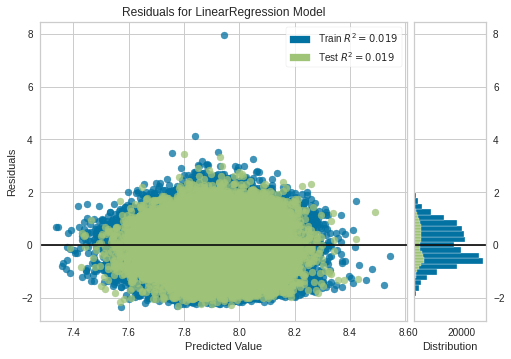

In [53]:
!pip install -U yellowbrick
from yellowbrick.regressor import ResidualsPlot

X_train, X_test, y_train, y_test=train_test_split(dataframe_train_raw, dataframe_target, test_size=0.2, random_state=0)

model=LinearRegression()
viz=ResidualsPlot(model)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()
plt.show()

2.) PREDICTING WITH SKLEARN

In [54]:
lr=LinearRegression()
lr.fit(dataframe_train_raw, dataframe_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
lr.coef_

array([-0.26801927,  0.13518656,  0.07260511,  0.10767227,  0.02063356,
        0.33849744,  0.15455708,  0.05324184,  0.04997986, -0.38969917,
        0.12132153,  0.15205167, -0.14200015, -0.0109773 ])

In [56]:
lr.intercept_

7.717064813141484

In [59]:
X_train, X_test, y_train, y_test=train_test_split(dataframe_train_raw, dataframe_target, test_size=0.2, random_state=0)

model=LinearRegression()
model.fit(X_train, y_train)
X_test['prediction']=model.predict(X_test)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Result with SKLEARN

In [60]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

mae_SKLEARN=mean_absolute_error(y_test, X_test['prediction'])
mse_SKLEARN=mean_squared_error(y_test, X_test['prediction'])
r2score_SKLEARN=r2_score(y_test, X_test['prediction'])

counter=0
X_test=pd.concat([X_test, y_test], axis=1)
X_test_list=X_test[['target', 'prediction']].values.tolist()
for i in X_test_list:
  if i[0]>0.8*i[1] and i[0]<1.2*i[1]:
    counter+=1


print('Mean absolute error using SKLEARN: {:.2}'.format(mae_SKLEARN))
print('Mean squared error using SKLEARN: {:.2}'.format(mse_SKLEARN))
print('R2 score using SKLEARN: {:.2}'.format(r2score_SKLEARN))
print("Prediction accuracy within -+20% range (with SKLEARN): {:.2%}".format(counter/len(X_test_list)))

Mean absolute error using SKLEARN: 0.61
Mean squared error using SKLEARN: 0.53
R2 score using SKLEARN: 0.019
Prediction accuracy within -+20% range (with SKLEARN): 98.08%


3.) IMPROVE THE PREDICTION with SKLEARN

a.) Select the most powerful features among the independent variables

In [61]:
!pip install shap

     |████████████████████████████████| 356 kB 6.7 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491650 sha256=ca864f136c52fc0bb6e993de2416cf6d2a24ddaeed91d68e8e2927b669e6ad41
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


Ranking the independent variables on the basis of their predicting power by Shap values

 Ranking of the features by predicting power according to SHAP values



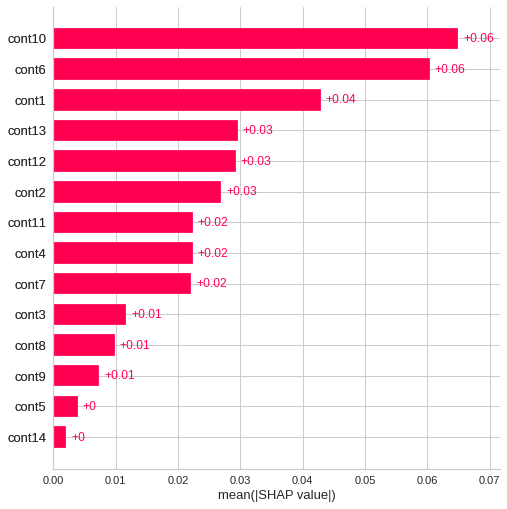

In [62]:



import shap
shap.initjs()

dataframe_original_ = pd.read_csv("/content/p/train.csv")

cols_independent=["cont1","cont2","cont3","cont4","cont5",
                "cont6","cont7","cont8","cont9","cont10","cont11","cont12","cont13","cont14" ]

print(" Ranking of the features by predicting power according to SHAP values\n")
X=dataframe_original_[cols_independent]
y=dataframe_original_['target']
model=LinearRegression().fit(X,y)
explainer=shap.Explainer(model, X)
shap_values=explainer(X)

shap.plots.bar(shap_values, max_display=14)


Analyse our features with Linear Regression Coefficients

Best performing features according to Linear Regression Coeficients (above the mean):  ['cont1', 'cont2', 'cont6', 'cont10', 'cont12', 'cont13']


Text(0.5, 1.0, 'Coefficients of the independent values')

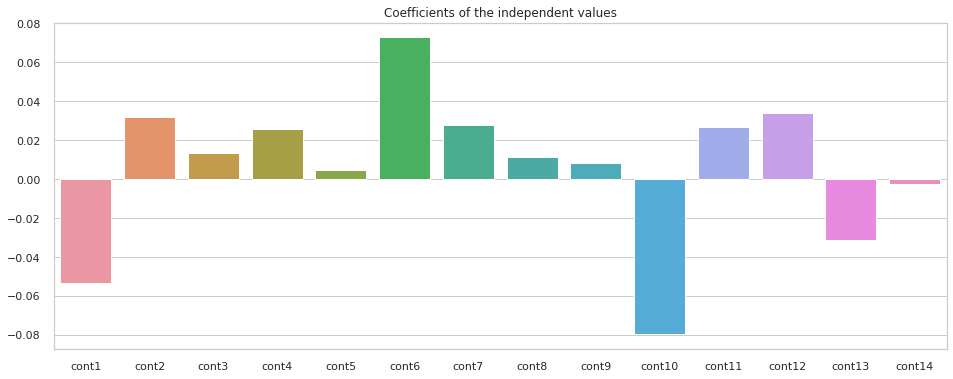

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel



cols_independent=["cont1","cont2","cont3","cont4","cont5",
                "cont6","cont7","cont8","cont9","cont10","cont11","cont12","cont13","cont14" ]

X_train, X_test, y_train, y_test=train_test_split(dataframe_original_[cols_independent], dataframe_original_['target'], test_size=0.2, random_state=0)


model=LinearRegression()

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


selector=SelectFromModel(LinearRegression())
selector.fit(X_train, y_train)

selector.get_support()

selected_features=dataframe_original_[cols_independent].columns[selector.get_support()]


coef=selector.estimator_.coef_
s=pd.Series(coef, cols_independent)
print("Best performing features according to Linear Regression Coeficients (above the mean): ", list(selected_features))
plt.figure(figsize=(16, 6))
sns.set_theme(style="whitegrid")
sns.barplot(x= cols_independent, y=coef).set_title("Coefficients of the independent values")



In [18]:
print("Rank of the best performing features")

s=pd.DataFrame(coef, cols_independent)
s.columns=["Coefficient"]
k=s.loc[np.abs(s["Coefficient"])>np.mean(np.abs(coef))]
#k.sort_values(["Coefficient"])
p=k.sort_values(by=["Coefficient"], key=abs, ascending=False)
p["Rank"]=[x+1 for x in range(len(p))]
p




Rank of the best performing features


,Coefficient,Rank
cont10,-0.079535,1
cont6,0.072695,2
cont1,-0.053259,3
cont12,0.033866,4
cont2,0.032097,5
cont13,-0.031214,6


With SHAP and COEFFICIENTS method we got the same 6 values as the most powerful ones. There is a slight difference only in the order, but this is not relevant.

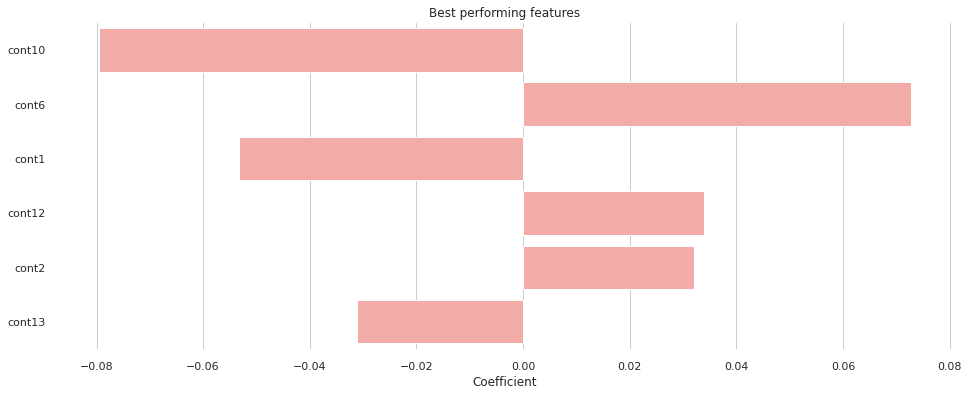

In [64]:
plt.figure(figsize=(16, 6))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(x=p.Coefficient, y=p.index, data=p, color="r").set_title("Best performing features")
sns.despine(left=True, bottom=True)


Experimenting with many technics.
 - As we have skewed features I tried to apply different transformations on them, Yeo-Johnson transformation has been proved to be the best
 - Boxplots showed that in case of some features we can find outlier values, so I tested if outlier removal by Windsorizer leads to better results
 - Polinomial regression technic in case there is quadratic relationship between feature and target
 - For the best feature/features selection I use Recursive Feature Elimination technic with Incremental approach

In [20]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
                

def run_outliers_transformation_NonLinear_Regression(df, cols, outliers=True, transformations_yeo=True, transformations_log=True):

  #fig, ax =plt.subplots(ncols=2, figsize=(14,7))

  #Reference plot

  X_train, X_test, y_train, y_test=train_test_split(df[cols], df["target"], test_size=0.2, random_state=0)

  X_train=X_train.reset_index(drop=True)  
  X_test=X_test.reset_index(drop=True)
  y_train=y_train.reset_index(drop=True)
  y_test=y_test.reset_index(drop=True)
  #model=LinearRegression()
  #model.fit(X_train, y_train)

  #visualizer=ResidualsPlot(model, ax=ax[0])
  #visualizer.fit(X_train, y_train)
  #visualizer.score(X_test, y_test)
  #plt.legend()

  #Residual plot with selected features and removed outliers and Yeo Johnson transformation
  if outliers==True:
    print("Outlier removal is selected")

    #X_train, X_test, y_train, y_test=train_test_split(df[cols], df["target"], test_size=0.2, random_state=0)

    winsorizer=Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=cols)  #remove outliers
    X_train=winsorizer.fit_transform(X_train)
    X_test=winsorizer.transform(X_test)



  #transformation yeo
  if transformations_yeo==True:
    print("Transformation_yeo is selected")

    transformer=PowerTransformer(method='yeo-johnson', standardize=True)
    X_train=transformer.fit_transform(X_train)
    X_test=transformer.transform(X_test)

    X_train=pd.DataFrame(X_train, columns=cols)
    X_test=pd.DataFrame(X_test, columns=cols)

  # transformation log
  if transformations_log==True:
    print("Transformation_log is selected")

    X_train=np.log(X_train)
    X_test=np.log(X_test)
    X_train.replace(np.nan, 0, inplace=True)
    X_test.replace(np.nan, 0, inplace=True)

  #non linear transformation

  polynomial=PolynomialFeatures(degree=2) #create a polynomial object                                          
  X_ptrain=polynomial.fit_transform(X_train)  #transform it into linear format
  polynomial.fit(X_train, y_train)

  model=LinearRegression()
  model.fit(X_ptrain, y_train)

  X_test['prediction']=model.predict(polynomial.fit_transform(X_test))

  mae_SKLEARN=mean_absolute_error(y_test, X_test['prediction'])
  mse_SKLEARN=mean_squared_error(y_test, X_test['prediction'])
  r2score_SKLEARN=r2_score(y_test, X_test['prediction'])

  counter=0
  X_test=pd.concat([X_test, y_test], axis=1)
  X_test_list=X_test[['target', 'prediction']].values.tolist()
  for i in X_test_list:
    if i[0]>0.8*i[1] and i[0]<1.2*i[1]:
      counter+=1


  print('Mean absolute error using SKLEARN: {:.2}'.format(mae_SKLEARN))
  print('Mean squared error using SKLEARN: {:.2}'.format(mse_SKLEARN))
  print('R2 score using SKLEARN: {:.2}'.format(r2score_SKLEARN))
  print("Prediction accuracy within -+20% range (with SKLEARN): {:.2%}".format(counter/len(X_test_list)))


  #visualizer=ResidualsPlot(model, ax=ax[1])
  #visualizer.fit(X_train, y_train)
  #visualizer.score(X_test, y_test)
  #plt.legend()

In [21]:
def incremental_RFE(n_features_to_select):
  from sklearn.feature_selection import RFE
  X_train, X_test, y_train, y_test=train_test_split(dataframe_original_[cols_independent], dataframe_original_['target'], test_size=0.2, random_state=0)

  # n_features_to_select=5 say we want the best 5 best performing features to select, step feature to be removed during 1 iteration

  model=LinearRegression()
  selector= RFE(model, n_features_to_select=n_features_to_select, step=1)

  selector.fit(X_train, y_train)
  selector.support_
  selected_features=list(X_train.columns[selector.support_])
  print("Selected features for training: ", selected_features)

  run_outliers_transformation_NonLinear_Regression(dataframe_original_, selected_features, outliers=True, transformations_yeo=True, transformations_log=False)

In [ ]:
incremental_RFE(1)

In [22]:
for i in range(1, len(cols_independent)+1):
  incremental_RFE(i)

Selected features for training:  ['cont12']
Outlier removal is selected
Transformation_yeo is selected
Mean absolute error using SKLEARN: 0.62
Mean squared error using SKLEARN: 0.54
R2 score using SKLEARN: 0.0022
Prediction accuracy within -+20% range (with SKLEARN): 97.86%
Selected features for training:  ['cont10', 'cont12']
Outlier removal is selected
Transformation_yeo is selected
Mean absolute error using SKLEARN: 0.62
Mean squared error using SKLEARN: 0.53
R2 score using SKLEARN: 0.0085
Prediction accuracy within -+20% range (with SKLEARN): 97.98%
Selected features for training:  ['cont1', 'cont10', 'cont12']
Outlier removal is selected
Transformation_yeo is selected
Mean absolute error using SKLEARN: 0.61
Mean squared error using SKLEARN: 0.53
R2 score using SKLEARN: 0.012
Prediction accuracy within -+20% range (with SKLEARN): 98.00%
Selected features for training:  ['cont1', 'cont6', 'cont10', 'cont12']
Outlier removal is selected
Transformation_yeo is selected
Mean absolute er

BEST RESULT </br>
</br>
- Without 'cont5' and cont14 variables</br>
- Outlier removal is selected</br>
- Transformation_yeo is selected</br>
- Polinomial regression technic is selected</br>
</br>
Mean absolute error using SKLEARN: 0.6</br>
Mean squared error using SKLEARN: 0.52</br>
Prediction accuracy within -+20% range (with SKLEARN): 98.18% (It is better value compared to figure you can achive with the standard models)</br>
R2 score using SKLEARN: 0.036  (it is better value than you can achive with the standard models)


4.) PREDICTING WITH PYTORCH (NEURAL NETWORKS LIBRARY)

In [23]:
#in this section you can run datapreprocessing (transformation, outlier removel)
# but for deep learning this is not important

dataframe_original = pd.read_csv("/content/p/train.csv")

dataframe_test = pd.read_csv("/content/p/test.csv")
dataframe_train_raw=dataframe_original.drop(['id'], axis=1)
dataframe_target=dataframe_train_raw.pop('target')

from sklearn.preprocessing import PowerTransformer

cols=['cont1', 'cont2','cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']


transformer=PowerTransformer(method='yeo-johnson', standardize=True)
X_train=transformer.fit_transform(dataframe_train_raw)
X_train=pd.DataFrame(X_train, columns=cols)

winsorizer=Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=cols)  #remove outliers
X_train=winsorizer.fit_transform(X_train)
  


dataframe_train_raw=pd.DataFrame(X_train, columns=cols)
dataframe_train00=pd.concat([dataframe_train_raw, dataframe_target], axis=1)


In [27]:
batch_size=128

In [35]:
# if you don't want to preprocess data you can start here:

batch_size=128

dataframe_test = pd.read_csv("/content/p/test.csv")

ID=dataframe_test[['id']].to_numpy(dtype=str)

inputs_test_array=dataframe_test[['cont1', 'cont2','cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']].to_numpy(dtype=np.float32)
test_tensor = torch.from_numpy(inputs_test_array)
test_dl = DataLoader(test_tensor, batch_size)

In [ ]:
dataframe_train00=pd.read_csv("/content/p/train.csv")

In [24]:

dataframe_train0 = dataframe_train00.copy(deep=True)

dataframe_train = dataframe_train0.sample(frac=1, random_state=8)
dataframe_train00.head()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,0.857720,1.442221,0.615233,-0.968654,-1.106741,1.400196,1.852693,-1.275041,0.631995,1.241613,1.711880,1.508174,1.323595,-0.960287,7.243043
1,-0.523761,0.506718,0.822144,0.054317,0.822308,-0.218213,0.284687,0.458977,-0.080416,-0.344073,-0.067041,-0.231256,-0.764346,-0.578486,8.203331
2,1.500074,-1.178123,-1.096989,-0.959793,0.688402,1.319134,0.258810,0.362338,0.763877,1.402915,0.504459,0.831160,1.335952,-0.975025,7.776091
3,1.448225,-1.430814,0.135513,0.935017,-1.120253,1.179499,1.384635,1.307068,0.705538,0.410965,1.251012,1.344365,1.426264,-1.124328,6.957716
4,1.847642,-0.392009,-1.085707,1.443089,0.896708,1.322074,0.151402,0.557641,1.814782,1.544279,1.879331,1.617889,1.486819,-0.216140,7.951046


In [25]:
inputs_array=dataframe_train[['cont1', 'cont2','cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']].to_numpy(dtype=np.float32)
targets_array=dataframe_train[['target']].to_numpy(dtype=np.float32)

inputs_tensor = torch.from_numpy(inputs_array)
targets_tensor= torch.from_numpy(targets_array)

dataset = TensorDataset(inputs_tensor, targets_tensor)

train_ds, val_ds =train_test_split(dataset, test_size=0.15, random_state=42)






In [28]:

batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

input_size=14
output_size=1

Building the linear regression model. </br> 
I experimented several hidden layers, but the deeper models didn't produce better results </br> 
I built an accuracy metric function into the modell giving -/+20% range leeway for the predicted values compared to the target value.

In [29]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

class Tabularplayground(nn.Module):
    def __init__(self):
        super().__init__()
      
        # hidden layer
        self.linear1 = nn.Linear(input_size, 512)
        self.batchnorm1=nn.BatchNorm1d(512)
        #hidden layer 2
        #self.linear2 = nn.Linear(2048, 1024)
        #self.batchnorm2=nn.BatchNorm1d(1024)
        # output layer
        #self.linear3 = nn.Linear(1024, 2048)
        #self.batchnorm3=nn.BatchNorm1d(2048)
        #self.linear4 = nn.Linear(2048, 1024)
        #self.batchnorm4=nn.BatchNorm1d(1024)
        #self.linear3 = nn.Linear(1024, 512)
        #self.batchnorm3=nn.BatchNorm1d(512)
        self.linear2 = nn.Linear(512, output_size)           
        
    def forward(self, xb):
        out = self.linear1(xb)
        out=self.batchnorm1(out)
        # Apply activation function
        #out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        #out = self.linear2(out)
        #out=self.batchnorm2(out)
        #out = self.linear3(out)
        #out=self.batchnorm3(out)
        # Apply activation function
        #out = F.relu(out)
        # Get predictions using output layer
        #out = self.linear4(out)
        #out=self.batchnorm4(out)
        #out = self.linear5(out)
        #out=self.batchnorm5(out)
        out = self.linear2(out)
        return out
    


    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)         
        loss = F.mse_loss(out, targets)                         
        return loss


    
    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)
        loss = F.mse_loss(out, targets) 
        acc = accuracy(out, targets)  
       
        R2=r2_score(out.detach().numpy().flatten(), targets.detach().numpy().flatten())
        return {'val_loss': loss.detach(), 'val_acc': acc, 'R2': R2}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        batch_R2 = [x['R2'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        #epoch_acc = torch.stack(batch_accs).mean()
        epoch_acc = sum(batch_accs)/len(batch_accs)
        epoch_R2 = sum(batch_R2)/len(batch_R2) 
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc, 'val_R2': epoch_R2}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        #if (epoch+1) % 2 == 0 or epoch == num_epochs-1:
        print("Epoch [{}], val_loss: {:.4f}, val_acc (+/-20% range): {:.4f}, val_R2: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc'], result['val_R2']))

def accuracy(outputs, labels):
    counter=0
    for i in range(len(labels)):
      if outputs[i]>labels[i]*0.8 and outputs[i]<labels[i]*1.2:
        counter +=1
    return counter/len(labels)

    #return torch.tensor(torch.sum(outputs == labels).item() / len(outputs))
    #return torch.tensor(torch.sum(outputs > labels*0.8 and outputs<labels*1.2).item() / len(outputs))


model = Tabularplayground()

Using GPU for computation if it is available

In [30]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [31]:
device = get_default_device()
device

device(type='cpu')

In [32]:
model = to_device(Tabularplayground(), device)

In [33]:


def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    #optimizer = opt_func(model.parameters(), max_lr)


    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                               steps_per_epoch=2*len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []


        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

   # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

              # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

Train-, val-, test dataloaders and the model transfered to the device for exploitation of the power of GPUs

In [35]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
#test_dl=DeviceDataLoader(test_dl, device)
to_device(model, device)

Tabularplayground(
  (linear1): Linear(in_features=14, out_features=512, bias=True)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
)

In [38]:
num_epochs = 30
#opt_func = torch.optim.Adam
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

history = fit(num_epochs, max_lr, model, train_dl, val_dl, grad_clip=grad_clip, 
                             weight_decay=weight_decay) 
                         #    opt_func=opt_func)

Epoch [1], val_loss: 0.5287, val_acc (+/-20% range): 0.9674, val_R2: -36.7982
Epoch [2], val_loss: 0.5258, val_acc (+/-20% range): 0.9667, val_R2: -51.3981
Epoch [3], val_loss: 0.5422, val_acc (+/-20% range): 0.9737, val_R2: -19.8276
Epoch [4], val_loss: 0.5319, val_acc (+/-20% range): 0.9746, val_R2: -35.9982
Epoch [5], val_loss: 0.5567, val_acc (+/-20% range): 0.9759, val_R2: -13.2632
Epoch [6], val_loss: 0.5287, val_acc (+/-20% range): 0.9755, val_R2: -33.3551
Epoch [7], val_loss: 0.5456, val_acc (+/-20% range): 0.9599, val_R2: -16.8484
Epoch [8], val_loss: 0.5331, val_acc (+/-20% range): 0.9712, val_R2: -21.4865
Epoch [9], val_loss: 0.5377, val_acc (+/-20% range): 0.9793, val_R2: -32.0989
Epoch [10], val_loss: 0.5278, val_acc (+/-20% range): 0.9680, val_R2: -22.3676
Epoch [11], val_loss: 0.5259, val_acc (+/-20% range): 0.9675, val_R2: -25.5807
Epoch [12], val_loss: 0.5312, val_acc (+/-20% range): 0.9639, val_R2: -47.1725
Epoch [13], val_loss: 0.5361, val_acc (+/-20% range): 0.9782,

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [57]:
print("Prediction accuracy with -+20% range (with PYTORCH): {:.2%}".format(history[-1]['val_acc']))
print('Mean squared error using (with PYTORCH): {:.2}'.format(history[-1]['val_loss']))
print('R2 score using (with PYTORCH): {:.2}'.format(history[-1]['val_R2']))


Prediction accuracy with -+20% range (with PYTORCH): 97.26%
Mean squared error using (with PYTORCH): 0.52
R2 score using (with PYTORCH): -4.9e+01


Making predictions for the test dataset and write the result into a csv file

In [ ]:
test_result=[]

for batch in test_dl:
  outputs_test = model(batch)
  test_result.append(outputs_test)

print(test_result[0])
 

In [ ]:
len(test_result)

In [ ]:
 test_numpy=[]
 for i in test_result:
   i2=i.cpu().detach().numpy()
   test_numpy.append(i2)

test_numpy_array=np.concatenate(test_numpy)




In [ ]:
id=ID.reshape(1,200000)
Test_Numpy_Array=test_numpy_array.reshape(1,200000)



arr = np.concatenate((id, Test_Numpy_Array), axis=0)


print("id", "     ", "target")

for i in range(len(arr[0])):
  print(arr[0][i], " ", arr[1][i])



In [ ]:
import csv

with open("mycsv", 'w') as f:
  thewriter=csv.writer(f)

  thewriter.writerow(['id', 'target'])
  for i in range(len(arr[0])):
    thewriter.writerow([arr[0][i], arr[1][i]])




In [ ]:
finaldoc = pd.read_csv("/content/mycsv")
finaldoc.head()

Download the csv file

In [ ]:
from google.colab import files
files.download('mycsv')

RESULT</br> 
</br> 
Deep neural network doesn't provide better results than the standard models

5.) XGBOOST

In [114]:
import pandas as pd
import xgboost as xgb
import numpy as np

In [120]:
X_train, X_test, y_train, y_test=train_test_split(dataframe_train_raw, dataframe_target, test_size=0.2, random_state=0)

In [121]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor


                 #  )

model = XGBRegressor()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [125]:
model.fit(X_train, y_train)

[20:56:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [126]:
pred = model.predict(X_test)

In [98]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
pred = model.predict(X_test)
  
# RMSE Computation
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE : % f" %(rmse))

RMSE :  2.679968


In [127]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
mae_XGBOOST=mean_absolute_error(y_test, pred)
mse_XGBOOST=mean_squared_error(y_test, pred)
r2score_XGBOOST=r2_score(y_test, pred)

counter=0
pred2=pred.tolist()
y_test2=y_test.tolist()
initial_data = {'target':y_test2,'Prediction':pred2}
X_test_list= pd.DataFrame(initial_data)

X_test_list=X_test_list.values.tolist()
for i in X_test_list:
  if i[0]>0.8*i[1] and i[0]<1.2*i[1]:
    counter+=1


print('Mean absolute error using XGBOOST: {:.2}'.format(mae_XGBOOST))
print('Mean squared error using XGBOOST: {:.2}'.format(mse_XGBOOST))
print('R2 score using XGBOOST: {:.2}'.format(r2score_XGBOOST))
print("Prediction accuracy within -+20% range (with XGBOOST): {:.2%}".format(counter/len(X_test_list)))


Mean absolute error using XGBOOST: 0.6
Mean squared error using XGBOOST: 0.51
R2 score using XGBOOST: 0.057
Prediction accuracy within -+20% range (with XGBOOST): 98.25%


RESULT: XGBOOST produced the best results for this dataset:</br>
</br>
Mean absolute error using XGBOOST: 0.6</br>
Mean squared error using XGBOOST: 0.51</br>
R2 score using XGBOOST: 0.057</br>
Prediction accuracy within -+20% range (with XGBOOST): 98.25%</br>